In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
COLORS = [(44/255, 160/255, 44/255, 1),#David  
          (31/255, 119/255, 180/255, 1), #Arturo
          (214/255, 39/255, 40/255, 1), #Isela     
          (255/255, 127/255, 14/255, 1),#Adriano
          (255/255, 231/255, 23/255, 1)]#George

COLORS2 = [(255/255, 127/255, 14/255, 1),#Arturo
           (31/255, 119/255, 180/255, 1),#Adriano
           (44/255, 160/255, 44/255, 1),#David 
           (255/255, 231/255, 23/255, 1),#George
           (214/255, 39/255, 40/255, 1)]#Isela      

COLORS3 = [(44/255, 160/255, 44/255, 1),#David 
           (31/255, 119/255, 180/255, 1),#Arturo
           (214/255, 39/255, 40/255, 1),#Isela    
           (255/255, 127/255, 14/255, 1),#Adriano
           (255/255, 231/255, 23/255, 1)]#George

In [4]:
df = pd.read_csv('./out/database.csv')

In [5]:
games_total = list()
for row in df['gid'].unique():
    games_total.append(df[df['gid'] == row]['game'].values[0])
    
games_names = list(set(games_total))
list1 = list()
list2 = list()
for i in games_names:
    print(i,games_total.count(i))
    list1.append(i)
    list2.append(games_total.count(i))
    
total_partidas_jogo = pd.DataFrame({'Games':list1,'Total':list2})

Misty 19
Saboteur 4
Kingdomino 16
CIV 6
Port Royal 32
Lhama 65
Ninja Camp 17
Munchkin 10
Encantados 109
Oh my goods 9
Bode of War 30
Kariba 32
Cartografos 5
Bohnanza 33


In [6]:
num_games_dia = df.groupby('date')['gid'].nunique()
dias_label = num_games_dia.keys()
dias_count = num_games_dia.values

Matriz_contador = np.zeros([len(num_games_dia),4])
for i in range(len(num_games_dia)):
    Dia = dias_label[i][0:2]
    Mes = dias_label[i][3:5]
    Ano = dias_label[i][6:8]
    
    Matriz_contador[i,0] = int(Dia)
    Matriz_contador[i,1] = int(Mes)
    Matriz_contador[i,2] = int(Ano)
    Matriz_contador[i,3] = int(dias_count[i])

In [7]:
df_games_dia = pd.DataFrame({'dia':Matriz_contador[:,0],'mes':Matriz_contador[:,1],
                             'ano':Matriz_contador[:,2],'num':Matriz_contador[:,3]})
df_games_dia_sort = df_games_dia.sort_values(['ano', 'mes', 'dia'], ascending=[True, True, True])
df_games_dia_sort = df_games_dia_sort.reset_index(drop=True)

In [8]:
time_vector = []
for i in range(len(num_games_dia)):
    time_vector.append(str(int(df_games_dia_sort['dia'][i])).zfill(2)+'/'+str(int(df_games_dia_sort['mes'][i])).zfill(2)+'/'+str(int(df_games_dia_sort['ano'][i])))

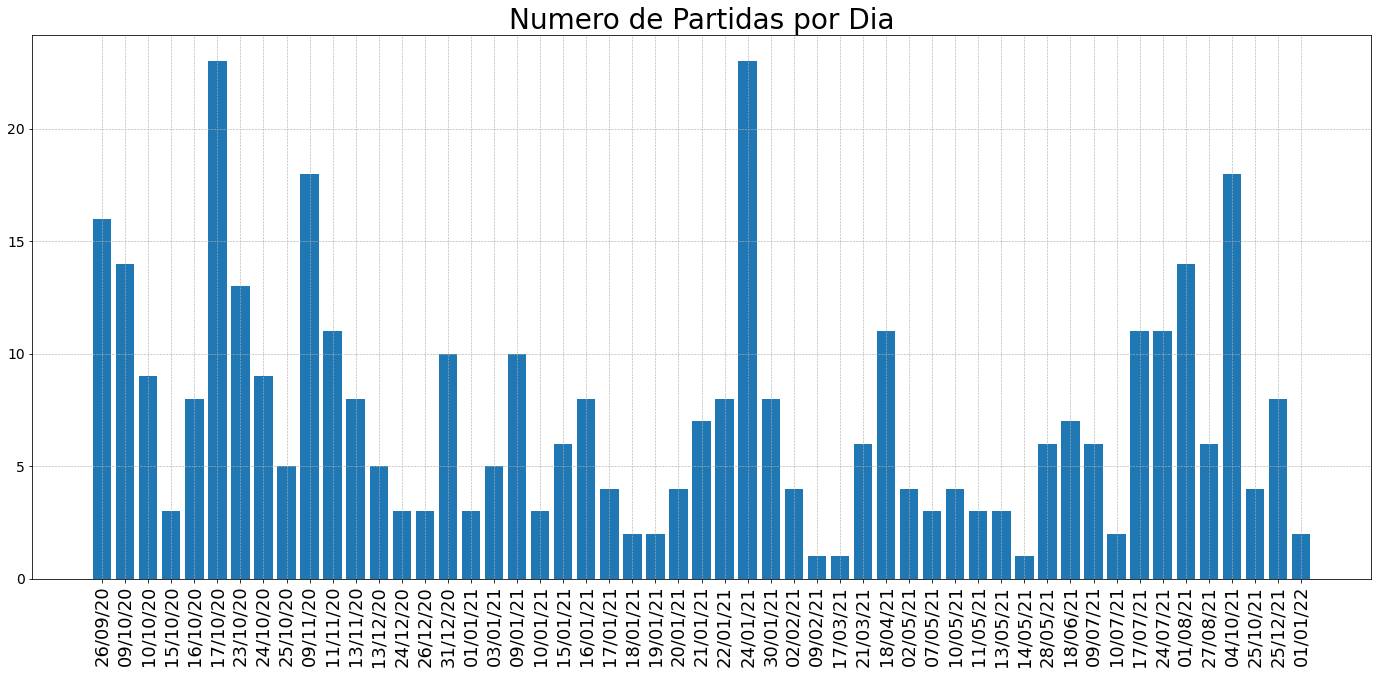

In [9]:
contador = np.arange(0,len(df_games_dia))
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
rects1 = ax.bar(contador,df_games_dia_sort['num'])
# plt.ylabel('Numero de Partidas',fontsize=18)
plt.grid(linestyle='--', linewidth=0.6)
plt.xticks(contador,time_vector, rotation='vertical',fontsize=18)
plt.title('Numero de Partidas por Dia',fontsize=28)
plt.savefig('./fig/partidas_dia.png',facecolor='w',bbox_inches ='tight',pad_inches=0.1)

In [10]:
list_mo = df_games_dia_sort['mes'].unique()
list_yr = df_games_dia_sort['ano'].unique()
print(list_mo)
print(list_yr)

[ 9. 10. 11. 12.  1.  2.  3.  4.  5.  6.  7.  8.]
[20. 21. 22.]


In [11]:
new_m = []
new_y = []
new_c = []

count_ = 0
for y in list_yr:
    for m in list_mo:
        total_mensual = df_games_dia_sort.loc[(df_games_dia_sort['mes'] == m) & (df_games_dia_sort['ano'] == y), 'num'].sum()
        if total_mensual != 0:
            print(str(int(m)).zfill(2),str(int(y)).zfill(2),total_mensual)
            new_m.append(str(int(m)).zfill(2))
            new_y.append(str(int(y)).zfill(2))
            new_c.append(total_mensual)       

09 20 16.0
10 20 84.0
11 20 37.0
12 20 21.0
10 21 22.0
12 21 8.0
01 21 93.0
02 21 5.0
03 21 7.0
04 21 11.0
05 21 24.0
06 21 7.0
07 21 30.0
08 21 20.0
01 22 2.0


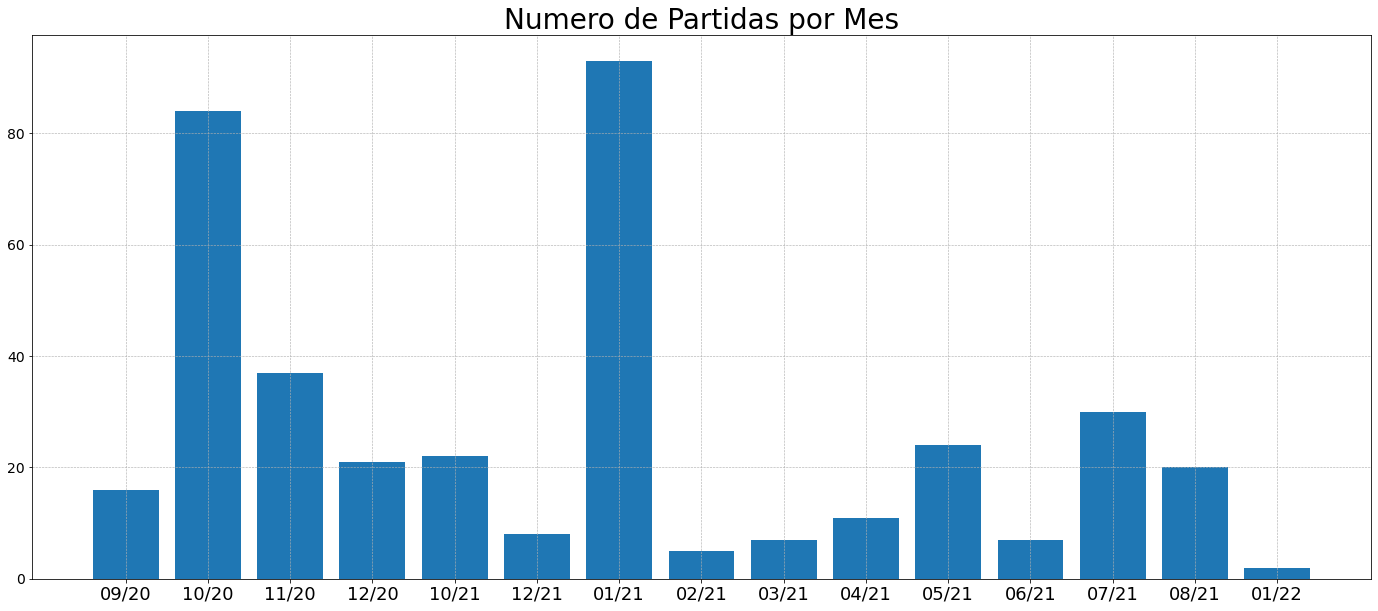

In [12]:
contador = np.arange(0,len(new_c))
label = [x +'/'+ y for x, y in zip(new_m, new_y)]
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
rects1 = ax.bar(contador,new_c)
# plt.ylabel('Numero de Partidas',fontsize=18)
plt.grid(linestyle='--', linewidth=0.6)
plt.xticks(contador,label,fontsize=18)
plt.title('Numero de Partidas por Mes',fontsize=28)
plt.savefig('./fig/partidas_mes.png',facecolor='w',bbox_inches ='tight',pad_inches=0.1)

In [13]:
lista_fi = df.drop_duplicates(subset=['gid'])
lista_fi = lista_fi.reset_index(drop=True)
list_win = lista_fi['winner']

In [14]:
player_vector = df['winner'].unique()
racha_total = np.zeros([len(df['winner'].unique())])
for num in range(len(df['winner'].unique())):
    print(num,player_vector[num])
    winner = player_vector[num]
    racha = 0
    racha_list = []
    for t in range(len(list_win)-1):
        if list_win[t] == winner and list_win[t+1] == winner:
            racha = racha + 1
            racha_list.append(racha)
        else:
            racha = 0
    if not racha_list:
        print('vacia')
        racha_total[num] = 0
    else:
        print(num,racha_list)
        print('Racha maxima: ',max(racha_list))
        print()
        racha_total[num] = max(racha_list)

0 Isela
0 [1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 3, 4, 1, 1, 2]
Racha maxima:  4

1 David
1 [1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 5, 1, 2, 1, 2, 1, 1, 1]
Racha maxima:  5

2 Arturo
2 [1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 3, 4, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 5, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 2, 1, 1, 2, 3, 4, 5, 6, 7, 1, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2]
Racha maxima:  7

3 Adriano
3 [1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 3]
Racha maxima:  3

4 George
vacia


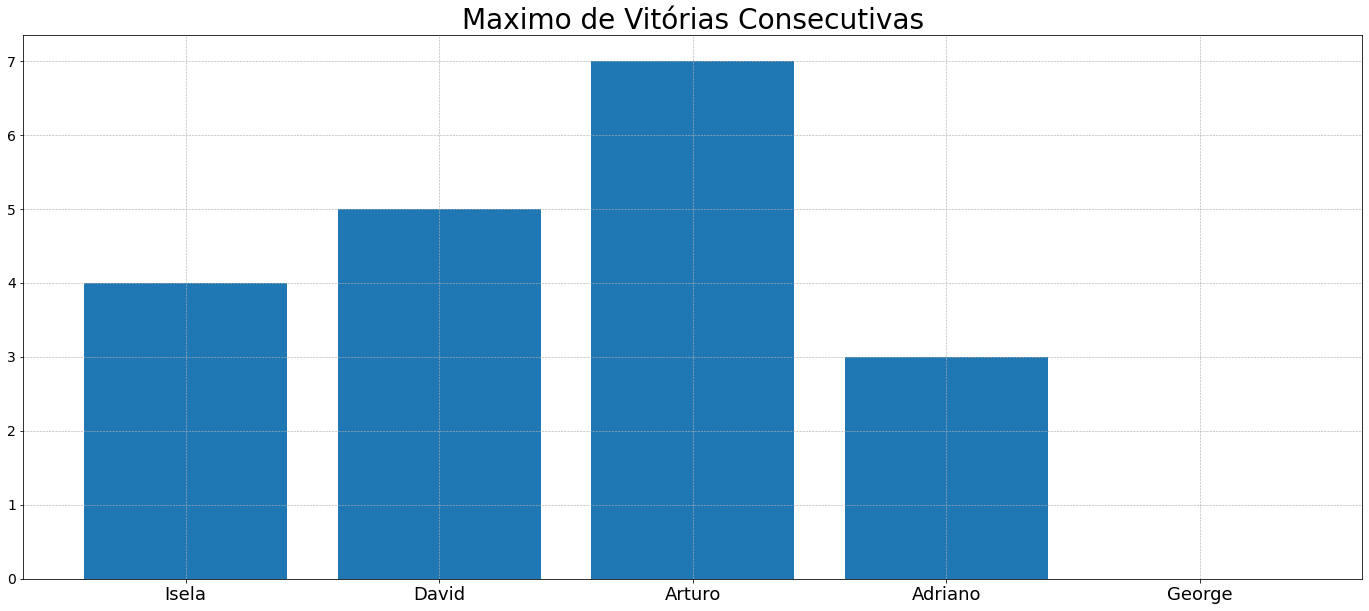

In [15]:
contador = np.arange(0,len(df['winner'].unique()))
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
rects1 = ax.bar(contador,racha_total)
plt.grid(linestyle='--', linewidth=0.6)
plt.xticks(contador,df['winner'].unique(),fontsize=18)
plt.title('Maximo de Vitórias Consecutivas',fontsize=28)
plt.savefig('./fig/rachas_max.png',facecolor='w',bbox_inches ='tight',pad_inches=0.1)

In [16]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [17]:
winners = list()
for row in df['gid'].unique():
    winners.append(df[df['gid'] == row]['winner'].values[0])

In [18]:
games_by_players = df.groupby(['game', 'players']).agg({'players': ['count']})#.reset_index()
games_by_players.head()

players
                      count
game        players        
Bode of War Adriano      27
            Arturo       30
            David        25
            George        1
            Isela        24

In [19]:
total_games = games_by_players['players'].groupby(['players']).agg({'count': 'sum'})
total_games.head()

,count
players,
Adriano,304
Arturo,380
David,253
George,16
Isela,378


In [20]:
players_names = df['players'].unique()

total_efficience = dict()
hist_winners = dict()

for player in players_names:
    player_df = total_games.loc[player]['count']
    victories = len(list(
        filter(
            lambda i: i == player, winners
        )
    ))
    total_efficience[player] = (victories/player_df)*100
    hist_winners[player] = victories

In [21]:
game_efficience = dict(game = list(), player = list(), efficience = list())
for player in df['players'].unique():
    for game in df['game'].unique():
        vic = df.query("game == '{0}' and players == '{1}' and winner == '{1}'".format(game, player))
        try:
            par = games_by_players.loc[game].loc[player][0]
            game_efficience['game'].append(game)
            game_efficience['player'].append(player)
            game_efficience['efficience'].append((vic.count()[0]/par)*100)
        except KeyError:
            game_efficience['game'].append(game)
            game_efficience['player'].append(player)
            game_efficience['efficience'].append(0)

game_efficience = pd.DataFrame(game_efficience).astype({'efficience': int})
game_efficience.head()

,game,player,efficience
0,Lhama,David,33
1,Port Royal,David,13
2,Munchkin,David,20
3,Encantados,David,21
4,Saboteur,David,0


In [22]:
game_pivot = game_efficience.pivot("game", "player", "efficience")
game_pivot

player,Adriano,Arturo,David,George,Isela
game,,,,,
Bode of War,18,20,44,0,33
Bohnanza,8,33,17,0,48
CIV,50,33,0,0,16
Cartografos,50,60,25,0,0
Encantados,21,49,21,25,23
Kariba,28,40,34,0,15
Kingdomino,14,37,10,100,40
Lhama,21,35,33,50,21
Misty,15,52,33,0,15


In [23]:
# Agregando la columna Game a game_pivot
idx = 0
#new_col = ('Bohnanza','Encantados','Lhama','Munchkin','Ninja Camp','Port Royal','Saboteur','Kariba','Oh my goods')
new_col = (game_pivot.index[0],game_pivot.index[1],game_pivot.index[2],game_pivot.index[3],
           game_pivot.index[4],game_pivot.index[5],game_pivot.index[6],game_pivot.index[7],
           game_pivot.index[8],game_pivot.index[9],game_pivot.index[10],game_pivot.index[11],
           game_pivot.index[12],game_pivot.index[13])
game_pivot.insert(loc=idx, column='Game', value=new_col)
game_pivot

player,Game,Adriano,Arturo,David,George,Isela
game,,,,,,
Bode of War,Bode of War,18,20,44,0,33
Bohnanza,Bohnanza,8,33,17,0,48
CIV,CIV,50,33,0,0,16
Cartografos,Cartografos,50,60,25,0,0
Encantados,Encantados,21,49,21,25,23
Kariba,Kariba,28,40,34,0,15
Kingdomino,Kingdomino,14,37,10,100,40
Lhama,Lhama,21,35,33,50,21
Misty,Misty,15,52,33,0,15


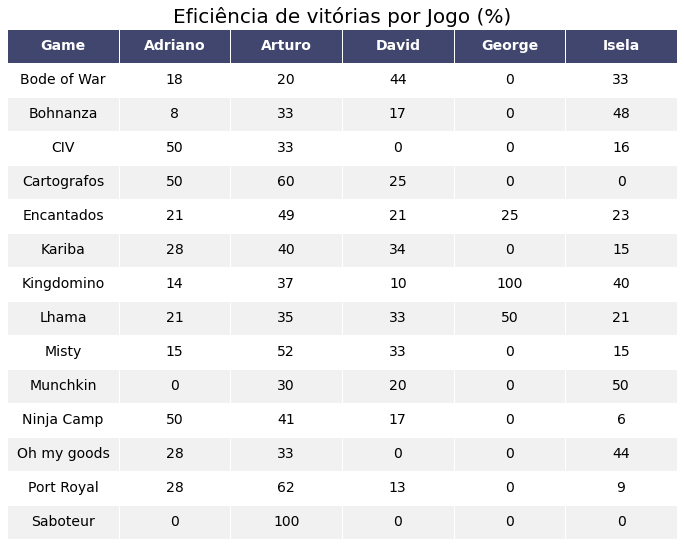

In [24]:
fig,ax = render_mpl_table(game_pivot, header_columns=0, col_width=2.0,cellLoc='center')
plt.title('Eficiência de vitórias por Jogo (%)')
fig.savefig("./fig/Eficiencia_por_jogo_table.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)

In [25]:
hist_winners.keys(),hist_winners.values()

(dict_keys(['David', 'Arturo', 'Isela', 'Adriano', 'George']),
 dict_values([63, 162, 92, 67, 3]))

In [26]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

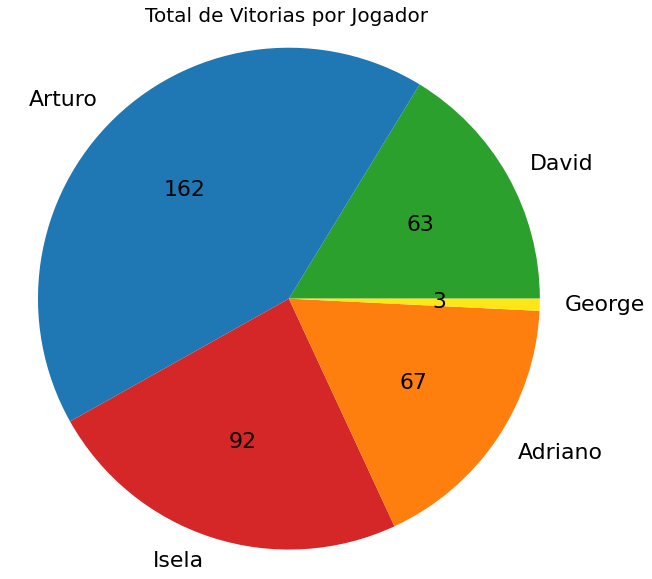

In [27]:
fig1, ax1 = plt.subplots(figsize=(10, 10))
plt.title('Total de Vitorias por Jogador')
# ax1.pie(hist_winners.values(),labels=hist_winners.keys(),autopct='%3.1f%%',colors=COLORS3,textprops={'fontsize':22})
ax1.pie(hist_winners.values(), labels = hist_winners.keys(),autopct=autopct_format(hist_winners.values()),
        colors=COLORS3,textprops={'fontsize':22})
ax1.axis('equal')
plt.savefig('./fig/pieplot_vitorias.png',facecolor='w',bbox_inches ='tight',pad_inches=0.1)

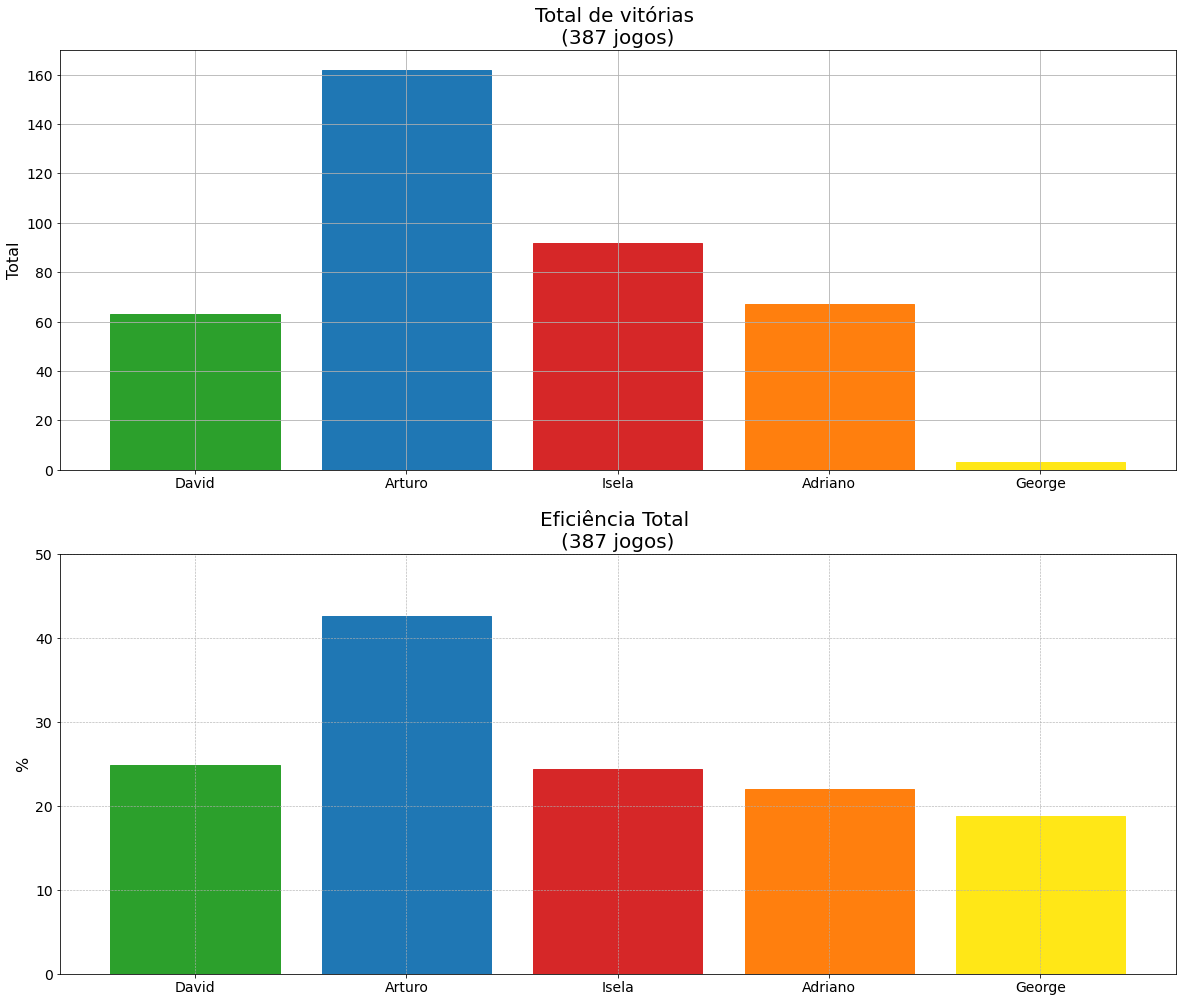

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20, 17))
ax[0].grid()
bars = ax[0].bar(hist_winners.keys(), hist_winners.values())
for i, color in enumerate(COLORS):
    bars[i].set_color(color)
ax[0].set_title('Total de vitórias \n(%d jogos)'%sum(hist_winners.values()))
ax[0].set_ylabel('Total')
plt.grid(linestyle='--', linewidth=0.6)

ax[1].grid()
bars = ax[1].bar(total_efficience.keys(), total_efficience.values())
for i, color in enumerate(COLORS):
    bars[i].set_color(color)
ax[1].set_title('Eficiência Total \n(%d jogos)'%sum(hist_winners.values()))
ax[1].set_ylim([0,50])
ax[1].set_ylabel('%')
plt.grid(linestyle='--', linewidth=0.6)

plt.savefig('./fig/general_statistics.png',facecolor='w',bbox_inches ='tight',pad_inches=0.1)

In [29]:
game_pivot

player,Game,Adriano,Arturo,David,George,Isela
game,,,,,,
Bode of War,Bode of War,18,20,44,0,33
Bohnanza,Bohnanza,8,33,17,0,48
CIV,CIV,50,33,0,0,16
Cartografos,Cartografos,50,60,25,0,0
Encantados,Encantados,21,49,21,25,23
Kariba,Kariba,28,40,34,0,15
Kingdomino,Kingdomino,14,37,10,100,40
Lhama,Lhama,21,35,33,50,21
Misty,Misty,15,52,33,0,15


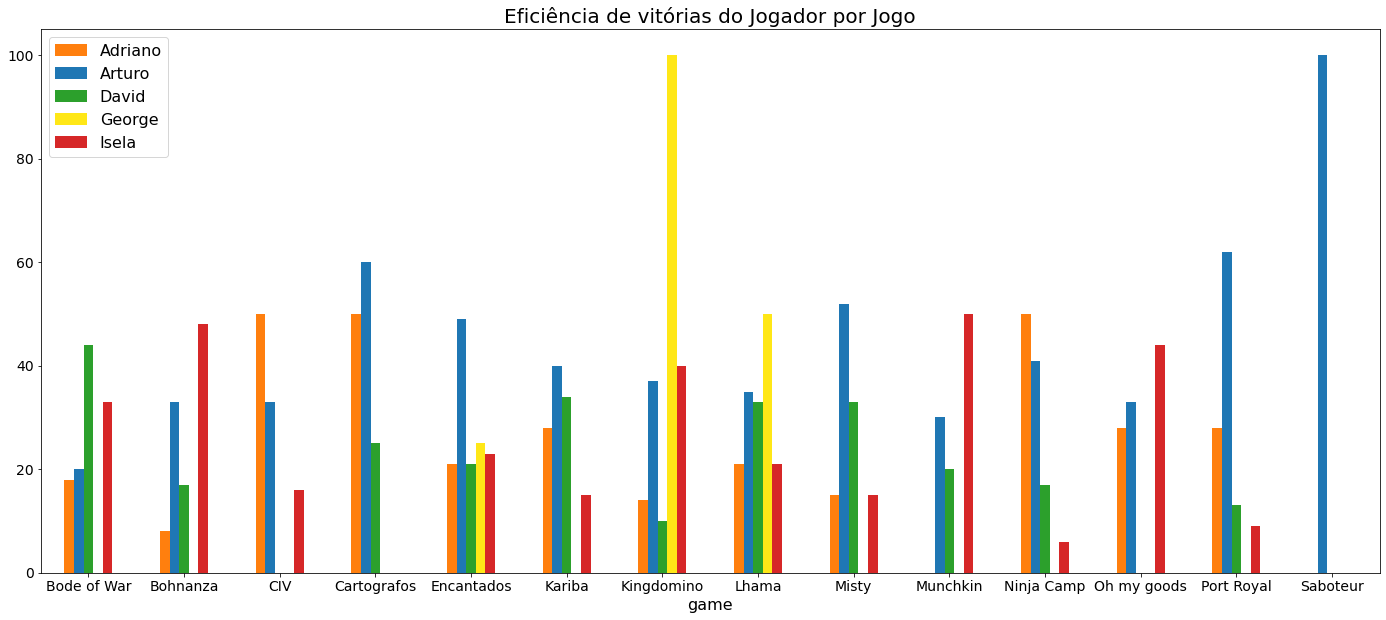

In [30]:
_, ax = plt.subplots(figsize=(24,10))
bars = game_pivot.plot(kind='bar', grid=True, ax=ax,color=COLORS2)
ax.tick_params(axis='x', rotation=0)
plt.title('Eficiência de vitórias do Jogador por Jogo')
plt.grid(linestyle='--', linewidth=0.6)
plt.legend(loc=2, prop={'size': 16})
plt.savefig("./fig/eficiencia_por_jogo.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)

David
Total de partidas:  253
Numero de Janelas:  25
[30, 50, 20, 20, 20, 10, 20, 10, 30, 20, 20, 20, 40, 30, 40, 10, 60, 30, 40, 30, 40, 20, 10, 10, 0]

Arturo
Total de partidas:  380
Numero de Janelas:  38
[20, 50, 60, 50, 60, 50, 40, 60, 40, 40, 60, 70, 30, 50, 40, 30, 50, 50, 30, 40, 30, 40, 40, 30, 60, 30, 40, 30, 60, 30, 30, 70, 40, 20, 40, 50, 30, 30]

Isela
Total de partidas:  378
Numero de Janelas:  37
[50, 0, 20, 30, 20, 10, 40, 30, 30, 40, 40, 0, 40, 30, 10, 50, 30, 40, 10, 10, 50, 30, 0, 0, 40, 20, 20, 10, 10, 10, 30, 0, 10, 60, 30, 20, 30]

Adriano
Total de partidas:  304
Numero de Janelas:  30
[20, 20, 10, 10, 20, 10, 20, 0, 40, 0, 10, 10, 30, 20, 30, 30, 20, 10, 30, 50, 10, 40, 30, 10, 20, 50, 30, 0, 50, 40]

George
Total de partidas:  16
Numero de Janelas:  1
[10]



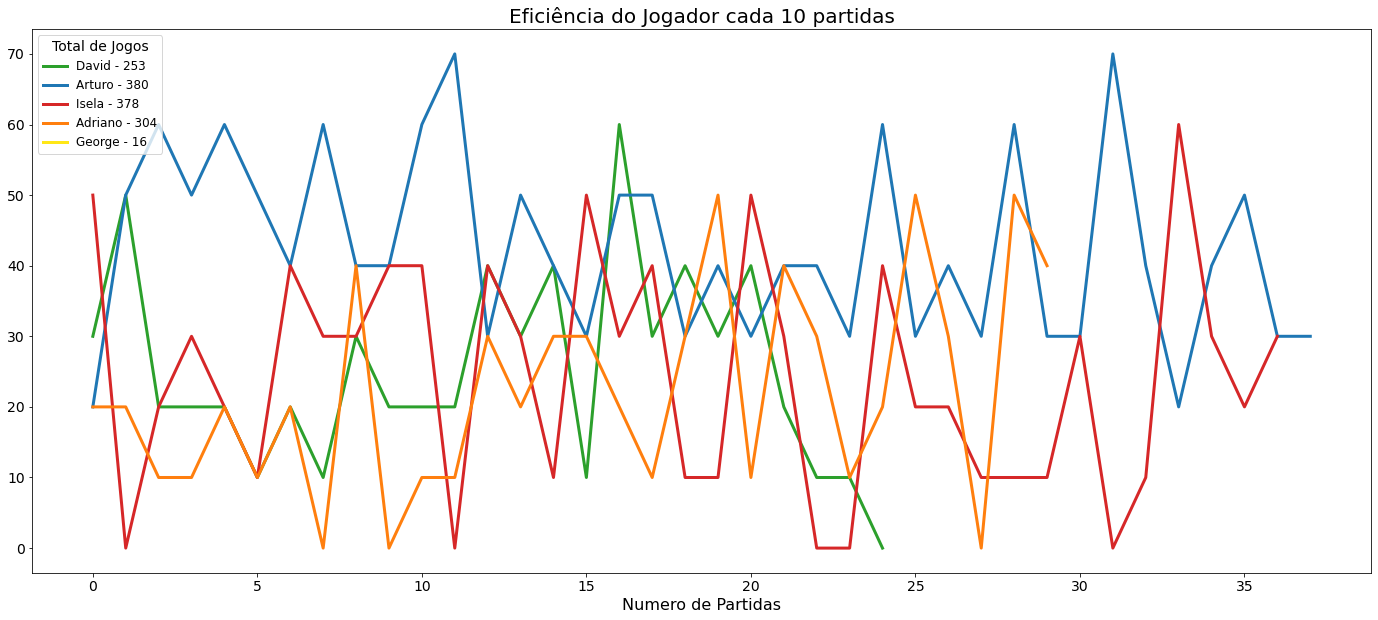

In [31]:
JN = 10
a = 0
df1 = df[['players', 'winner']]

plt.figure(figsize=(24,10))
ax = plt.axes()
for names in df1['players'].unique():

    print(names)

    test = dict()
    test = df1[df1['players'] == names]
    test.reset_index(drop=True, inplace=True)
    test.head()

    total_partidas_final = len(test)
    janelas = int(total_partidas_final/JN)
    print('Total de partidas: ',total_partidas_final)
    print('Numero de Janelas: ',janelas)

    list_player = list()
    for ii in range(janelas):
        list_player.append(int(((len(test[JN*ii:JN*ii+JN][test[JN*ii:JN*ii+JN]['winner'] == names]))/JN)*100))
    print(list_player)
    print()
    
    xx = np.arange(0,len(list_player))

    label_j = names +' - '+str(total_partidas_final)
    
    plt.plot(list(xx),list_player,linestyle='-',linewidth=3,color=COLORS[a],label=label_j)
    
    a = a + 1

vals = ax.get_yticks()
# ax.set_xticklabels(['%i' % np.round(y) for y in vals])    

plt.title('Eficiência do Jogador cada '+str(JN)+' partidas')
plt.xlabel('Numero de Partidas')
plt.grid(True)

leg = plt.legend(fontsize=12,loc=2)
leg.set_title(title="Total de Jogos",prop={'size':14})

plt.grid(linestyle='--', linewidth=0.6)

salida1 = './fig/eficiencia_cada_'+str(JN)+'.png'

plt.savefig(salida1,facecolor='w',bbox_inches ='tight',pad_inches=0.1)

David
Total de partidas:  253
Numero de Janelas:  16
[26, 40, 20, 13, 20, 20, 20, 20, 40, 33, 40, 26, 33, 40, 20, 6]

Arturo
Total de partidas:  380
Numero de Janelas:  25
[40, 46, 46, 60, 46, 46, 53, 60, 33, 46, 40, 46, 26, 40, 53, 20, 46, 40, 33, 46, 33, 60, 26, 46, 33]

Isela
Total de partidas:  378
Numero de Janelas:  25
[33, 13, 33, 6, 33, 33, 33, 20, 33, 20, 40, 40, 13, 33, 20, 0, 40, 13, 13, 6, 20, 6, 46, 26, 20]

Adriano
Total de partidas:  304
Numero de Janelas:  20
[13, 20, 20, 6, 13, 26, 6, 6, 33, 20, 20, 20, 33, 26, 40, 13, 26, 40, 20, 40]

George
Total de partidas:  16
Numero de Janelas:  1
[20]



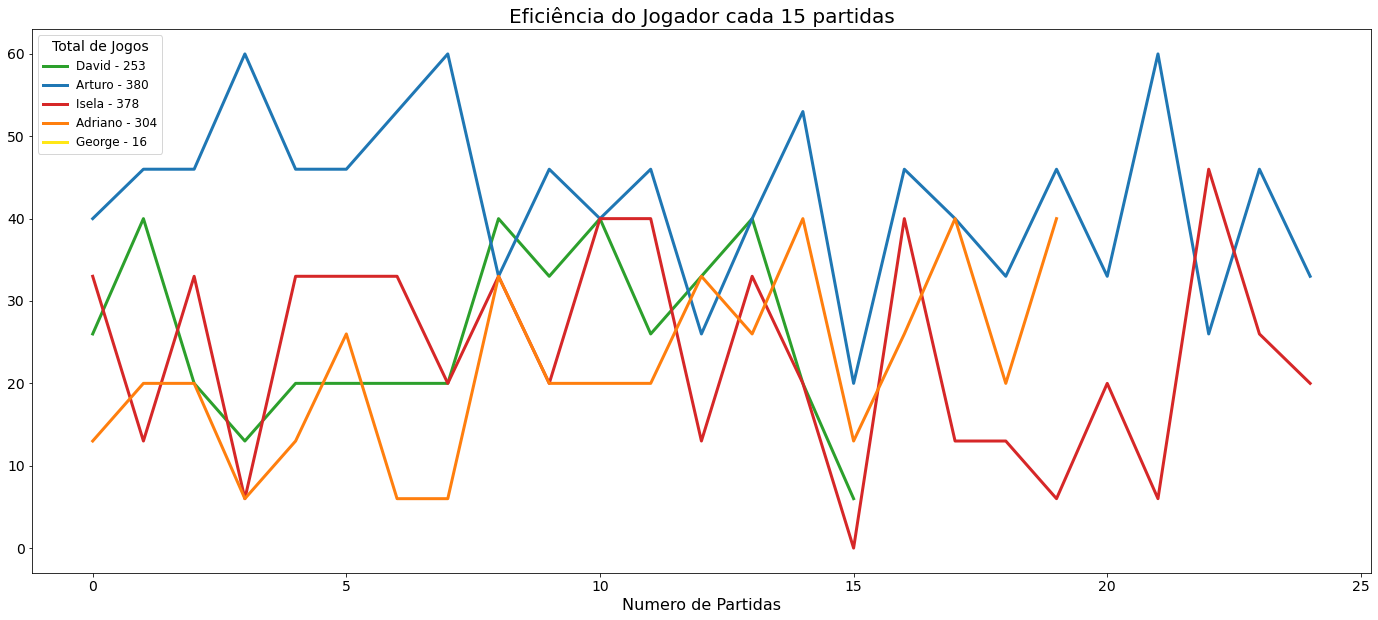

In [32]:
JN = 15
a = 0
df1 = df[['players', 'winner']]

plt.figure(figsize=(24,10))
ax = plt.axes()
for names in df1['players'].unique():

    print(names)

    test = dict()
    test = df1[df1['players'] == names]
    test.reset_index(drop=True, inplace=True)
    test.head()

    total_partidas_final = len(test)
    janelas = int(total_partidas_final/JN)
    print('Total de partidas: ',total_partidas_final)
    print('Numero de Janelas: ',janelas)

    list_player = list()
    for ii in range(janelas):
        list_player.append(int(((len(test[JN*ii:JN*ii+JN][test[JN*ii:JN*ii+JN]['winner'] == names]))/JN)*100))
    print(list_player)
    print()

    label_j = names +' - '+str(total_partidas_final)
    
    xx = np.arange(0,len(list_player))
    
    plt.plot(xx,list_player,linestyle='-',linewidth=3,color=COLORS[a],label=label_j)
    
    a = a + 1

vals = ax.get_yticks()
# ax.set_xticklabels(['%i' % np.round(y) for y in vals])    

plt.title('Eficiência do Jogador cada '+str(JN)+' partidas')
plt.xlabel('Numero de Partidas')
plt.grid(True)

leg = plt.legend(fontsize=12,loc=2)
leg.set_title(title="Total de Jogos",prop={'size':14})

plt.grid(linestyle='--', linewidth=0.6)

salida2 = './fig/eficiencia_cada_'+str(JN)+'.png'

plt.savefig(salida2,facecolor='w',bbox_inches ='tight',pad_inches=0.1)

In [33]:
games_sort = total_partidas_jogo.sort_values(by=['Total'])

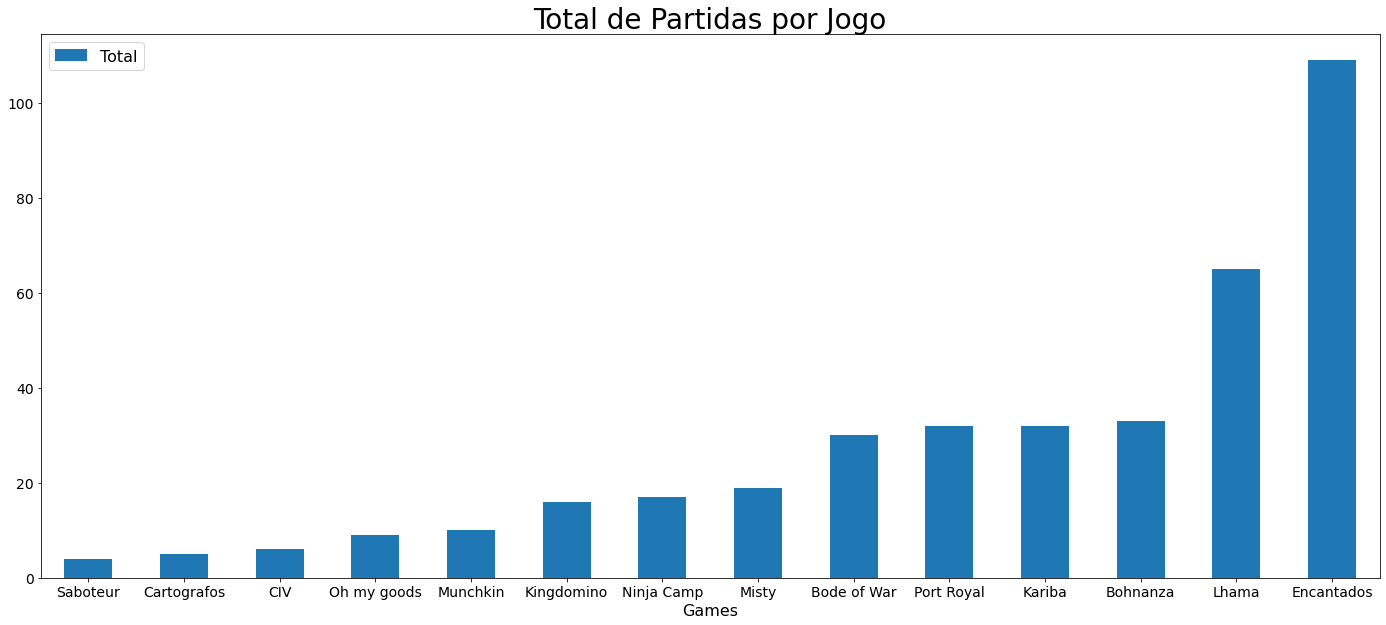

In [34]:
_, ax = plt.subplots(figsize=(24,10))
games_sort.plot.bar(x='Games',grid=True,y='Total',ax=ax)
ax.tick_params(axis='x', rotation=0)
plt.title('Total de Partidas por Jogo',fontsize=28)
plt.grid(linestyle='--', linewidth=0.6)
plt.legend(prop={'size': 16})
plt.savefig("./fig/Total_partidas.png",facecolor='w',bbox_inches ='tight',pad_inches=0.1)